In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from tqdm import tqdm
import timeit

Input data:  
- CCLE_expression.csv  
Gene expression TPM (transcript per million) values of the protein coding genes for DepMap cell lines  
log2(TPM+1) goes from 0.00 to 17.78


- CRISPR_gene_effect.csv
Gene effect of the protein coding genes for DepMap cell lines
Gene Effect scores derived from CRISPR knockout screens published by Broad’s Achilles and Sanger’s SCORE projects.  
Negative scores imply cell growth inhibition and/or death following gene knockout. Scores are normalized such that nonessential genes have a median score of 0 and independently identified common essentials have a median score of -1.
SCORE goes from -3.89 to 2.73. 

- preprocess/index_to_protein_and_gene.txt

- preprocess/adjacence_matrix.txt

Genes:16,481  
Cell Lines:1,081  
Primary Diseases:31 (?)  
Lineages:28 (?)

### Retrieve data 

In [2]:
gene_expression = pd.read_csv('preprocess/gene_expression.csv').set_index('DepMap')
gene_effect = pd.read_csv('preprocess/gene_effect.csv').set_index('DepMap')

In [3]:
protein_info = pd.read_csv('preprocess/index_to_protein_and_gene.txt', header=None, sep=' ')
protein_info = protein_info.rename(columns={0:'index', 1:'protein', 2:'gene_ID'})
protein_info = protein_info.set_index('index')

In [4]:
#adjacence_matrix = np.loadtxt('preprocess/adjacence_matrix.txt', delimiter=' ', dtype=int)
index_links = pd.read_csv("preprocess/index_links.csv")

### Creating Dataset

In [5]:
# gene effect and gene expression don't have the same number of rows for some reason.

In [6]:
indices = set(gene_effect.index).intersection(gene_expression.index)
indices = list(indices)
gene_effect_ = gene_effect[gene_effect.index.isin(indices)]
gene_expression_ = gene_expression[gene_expression.index.isin(indices)]

In [7]:
gene_expression_np = gene_expression_.to_numpy()
gene_effect_np = gene_effect_.to_numpy()

In [8]:
edge_index = index_links[['index1', 'index2']].to_numpy().T
edge_attr = index_links['combined_score'].to_numpy().reshape(-1,1)

**Separate Train / Test / Set**

In [9]:
# Ratio: 70 / 15 / 15
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gene_expression_np, gene_effect_np, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=1) # 0.85 x 0.18 ~= 0.15

**Normalize Data**

In [10]:
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scale_effect = StandardScaler()
scale_expression = StandardScaler()
scale_attr = MinMaxScaler()

X_train = scale_expression.fit_transform( X_train )
y_train = scale_effect.fit_transform( y_train )
scaled_attr = scale_attr.fit_transform( edge_attr )

# scale validation and test set

X_test = scale_expression.transform( X_test )
y_test = scale_effect.transform( y_test )

X_val = scale_expression.transform( X_val )
y_val = scale_effect.transform( y_val )

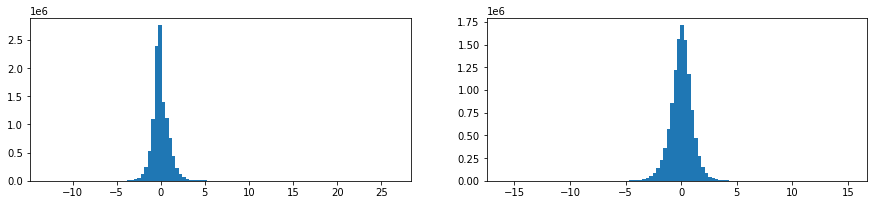

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15,3))
_ = ax[0].hist(np.hstack(X_train), bins = 100)
_ = ax[1].hist(np.hstack(y_train), bins = 100)

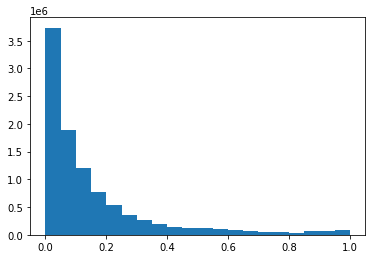

In [12]:
_ = plt.hist(scaled_attr[:,0], bins = 20)

**Change Data Type**

In [13]:
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

X_val = torch.tensor(X_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)

edge_index = torch.tensor(edge_index, dtype = torch.long)
edge_attr = torch.tensor(scaled_attr, dtype = torch.float32).view(-1, 1)

**Plot Graph**

In [14]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
import networkx as nx


def cool_plot_function(X_train, edge_index, N_nodes = 1_000, N_edges = 100_000):
    # This function selects N_nodes random nodes and N_edges random edges from the list. 
    # It then plots the nodes and the associated edges present in the edge subset. 
    
    random_indices_nodes = np.unique( np.sort( np.random.randint(0, 16_481, N_nodes) ) )
    x = X_train[0][random_indices_nodes]

    random_indices_edges = np.unique( np.sort( np.random.randint(0, edge_index.shape[1], N_edges) ) )
    edge_index_ = np.array( edge_index[:, random_indices_edges] )
    print(edge_index_.shape)

    edge_index_temp = []
    for i in tqdm(range(edge_index_.shape[1])):
        if (edge_index_[0, i] in random_indices_nodes) and (edge_index_[1, i] in random_indices_nodes):
            edge_index_temp.append(edge_index_[:, i])

    edge_index_ = np.vstack(edge_index_temp).T
    edge_index_final = np.zeros_like(edge_index_)

    for i in tqdm(range(edge_index_.shape[0])):
        for j in range(edge_index_.shape[1]):
            edge_index_final[i,j] = np.argwhere(random_indices_nodes == edge_index_[i,j])[0,0]

    edge_index_final = torch.tensor(edge_index_final, dtype = torch.long)
    x = torch.tensor(x, dtype = torch.long)
    data = Data(x = x, edge_index = edge_index_final)
    
    vis = to_networkx(data)
    nx.draw_networkx(vis, with_labels = False, node_size = 10)
    
    #plt.show(block=False)
    plt.savefig("imgs/Graph.png", format="PNG", bbox_inches = 'tight')
    plt.show()

(2, 99512)


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 135.52it/s]
C:\Users\matth\AppData\Local\Temp\ipykernel_20652\2174681174.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype = torch.long)


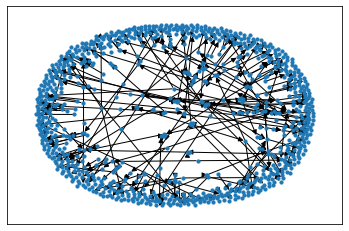

In [15]:
cool_plot_function(X_train, edge_index)

### Create Graph Model

In [22]:
from torch_geometric.nn import GCNConv, SAGEConv, GCN2Conv, GraphConv, GravNetConv, GatedGraphConv, ResGatedGraphConv, GATConv, GATv2Conv
from torch.nn import Linear

class GCN(torch.nn.Module):
    
    def __init__(self, edge_index, edge_attr, nb_layers, nb_filt):
        super().__init__()
        
        self.edge_attr = edge_attr
        self.edge_index = edge_index
        self.conv = GCNConv(1, nb_filt, edge_weights = self.edge_attr)
        self.linear = Linear(nb_filt, 1)
        self.nb_layers = nb_layers
        
    def forward(self, x):
        
        x = F.relu(x)
        for i in range(self.nb_layers):
            x = self.conv(x, edge_index = self.edge_index)
        x = self.linear(x)
        
        return x

In [23]:
n_epochs = 100
device = 'cuda'

import time

N_cl = X_train.shape[0] # Number of cell lines

X_train = X_train.to(device)
y_train = y_train.to(device)

# taking a subset of validation set
X_val_ = X_val[:10]
y_val_ = y_val[:10]

X_val_ = X_val_.to(device)
y_val_ = y_val_.to(device)

edge_attr = edge_attr.to(device)
edge_index = edge_index.to(device)

train_losses = []
val_losses = []

# model takes edge_index, edge_attr as inputs
nb_layers = 1
nb_filt = 10
model = GCN(edge_index, edge_attr, nb_layers, nb_filt)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)#, weight_decay=5e-4)



In [24]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

31


### Single-cell line method

In [19]:
model.train()
idx = 0
print("Training graph model on cell line: ", indices[idx] )


for epoch in tqdm(range(n_epochs)):
    # training
    optimizer.zero_grad()
    out = model(X_train[idx].view(-1,1))
    train_loss = F.mse_loss(out, y_train[idx].view(-1,1))
    train_loss.backward()   
    train_losses.append( train_loss.item() )
    optimizer.step()
    
    # validation loss
    with torch.no_grad():
        
        temp = []
        for i in range(X_val_.shape[0]):
            out = model(X_val_[i].view(-1,1))
            val_loss = F.mse_loss(out, y_val_[i].view(-1,1))
            temp.append( val_loss.item() )

        val_losses.append( np.mean( np.array(temp) ) )


Training graph model on cell line:  ACH-000160


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


In [20]:
data_1cl_1layer = [train_losses, val_losses]
#data_1cl_2layer = [train_losses, val_losses]

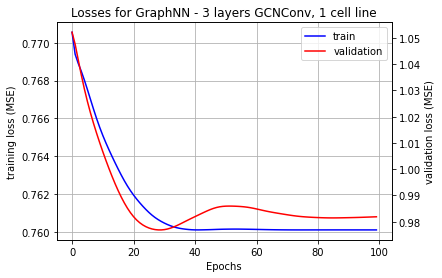

In [21]:
#plt.plot(train_losses)
fig, ax = plt.subplots()

lns1 = ax.plot(train_losses, 'b', label = 'train')
ax2 = ax.twinx()
lns2 = ax2.plot(val_losses, 'r', label = 'validation')

#ax.legend(['train'])
#ax2.legend(['validation'], loc = 'lower right')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_title('Losses for GraphNN - 3 layers GCNConv, 1 cell line')
ax.set_xlabel('Epochs')
ax.set_ylabel('training loss (MSE)')
ax2.set_ylabel('validation loss (MSE)')

ax.grid('on')
plt.savefig('3layerconvGNN_1cl.png', bbox_inches = 'tight')

In [25]:
# prediction of model on test set
X_test = X_test.to(device)
y_test = y_test.to(device)

test_error_mat = np.zeros(X_test.shape)

model.eval()

for i in tqdm(range(X_test.shape[0])):
    out = model(X_test[i].view(-1, 1))
    out = out - y_test[i:i+1].T # predicted - real
    test_error_mat[i] = out.detach().cpu().numpy().reshape(-1)

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:09<00:00, 15.76it/s]


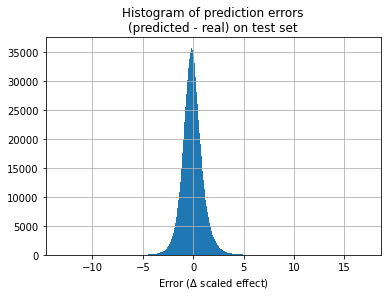

In [26]:
# Plot distribution of dependency score error (test set)

fig, ax = plt.subplots()
_ = ax.hist(test_error_mat.flatten(), bins = 1000)
ax.set_title("Histogram of prediction errors\n(predicted - real) on test set")
ax.set_xlabel("Error ($\Delta$ scaled effect)")
ax.grid("on")


### Multiple-cell lines method

In [28]:
n_epochs = 100
device = 'cuda'

import time

N_cl = X_train.shape[0] # Number of cell lines
N_cl_per_epo = 10 #int( 0.01 * N_cl ) # Number of cell lines per epoch

X_train = X_train.to(device)
y_train = y_train.to(device)

# taking a subset of validation set
X_val_ = X_val[:10]
y_val_ = y_val[:10]

X_val_ = X_val_.to(device)
y_val_ = y_val_.to(device)

edge_attr = edge_attr.to(device)
edge_index = edge_index.to(device)

val_losses_layers_multicell = np.zeros((3, n_epochs))

In [31]:
# model takes edge_index, edge_attr, nb_layers as inputs

train_losses = []
val_losses = []
nb_layers = 1
nb_filt = 10
model = GCN(edge_index, edge_attr, nb_layers, nb_filt)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=5e-4)

model.train()

for epoch in tqdm(range(n_epochs)):
    # training
    rand_index = np.random.randint(0, N_cl, N_cl_per_epo)
    for i in range(N_cl_per_epo):
        idx = rand_index[i]
        optimizer.zero_grad()
        out = model(X_train[idx].view(-1,1))
        train_loss = F.mse_loss(out, y_train[idx].view(-1,1))
        train_loss.backward()   
        if (epoch == 0 and i == 0) or (i == N_cl_per_epo - 1):
            train_losses.append( train_loss.item() )
            optimizer.step()

    # validation loss
    with torch.no_grad():

        temp = []
        for i in range(X_val_.shape[0]):
            out = model(X_val_[i].view(-1,1))
            val_loss = F.mse_loss(out, y_val_[i].view(-1,1))
            temp.append( val_loss.item() )
        val_losses.append( np.mean( np.array(temp) ) )


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.98s/it]


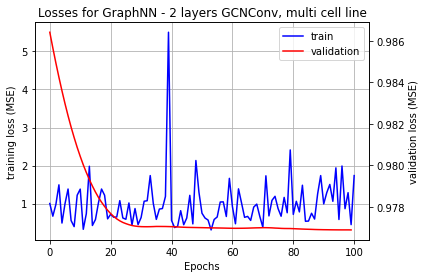

In [32]:
#plt.plot(train_losses)
fig, ax = plt.subplots()

lns1 = ax.plot(train_losses, 'b', label = 'train')
ax2 = ax.twinx()
lns2 = ax2.plot(val_losses, 'r', label = 'validation')

#ax.legend(['train'])
#ax2.legend(['validation'], loc = 'lower right')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_title('Losses for GraphNN - 2 layers GCNConv, multi cell line')
ax.set_xlabel('Epochs')
ax.set_ylabel('training loss (MSE)')
ax2.set_ylabel('validation loss (MSE)')

ax.grid('on')
plt.savefig('2layerconvGNN_multicl.png', bbox_inches = 'tight')

In [33]:
val_loss_multi = val_losses
train_loss_multi = train_losses

Text(0.5, 0, 'Epochs')

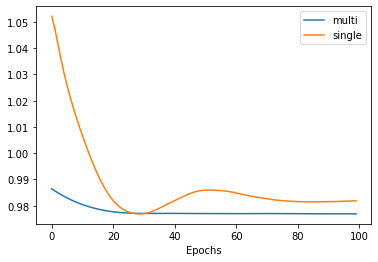

In [35]:
fig, ax = plt.subplots()
ax.plot(val_loss_multi, label="multi")
ax.plot(data_1cl_1layer[1], label="single")
ax.legend()
ax.set_xlabel("Epochs")